# Jax Neural Network
---
This notebook accompanies the `Training a Neural Network with Jax` [blog post](https://enerrio.bearblog.dev/training-a-neural-network-with-jax/) that walks through this code.

In [1]:
import jax
import copy
import time
from jax import random
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt

%matplotlib inline

## Create Dataset

In [2]:
def generate_polynomial_data(key, coefficients=[1, -2, 3], n_samples=100):
    key, subkey = random.split(key, 2)
    X = jnp.linspace(-10, 10, n_samples)
    y = jnp.polyval(coefficients, X) + random.normal(subkey, shape=(n_samples,))
    return X.reshape(-1, 1), y.reshape(-1, 1), key

key = random.key(21)
X, y, key = generate_polynomial_data(key, coefficients=jnp.array([1, -2, 1, -2]), n_samples=1_000)
X_norm = (X - X.mean()) / X.std()
y_norm = (y - y.mean()) / y.std()

print(f"X shape: {X.shape} - X dtype: {X.dtype}")
print(f"y shape: {y.shape} - y dtype: {y.dtype}")

X shape: (1000, 1) - X dtype: float32
y shape: (1000, 1) - y dtype: float32


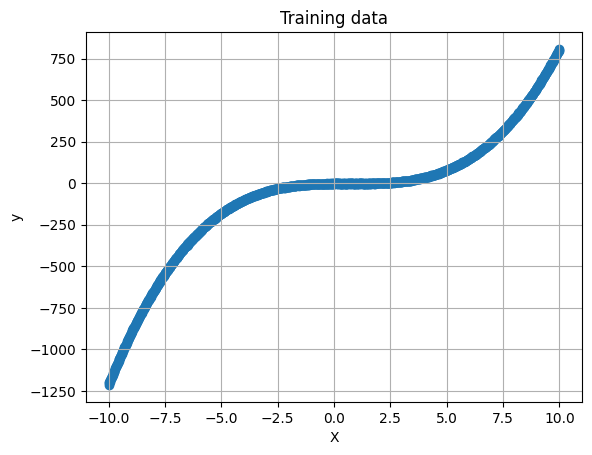

In [3]:
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Training data")
plt.grid(True);

## Model Training Functions

In [4]:
# Create model parameters
def init_params(key):
    """Initialize model weights w/ Kaiming init."""
    W1_key, W2_key = random.split(key, 2)
    W1 = random.normal(W1_key, (1, 128), dtype=jnp.float32) * (5/3) / jnp.sqrt(1.)
    b1 = jnp.zeros(128, dtype=jnp.float32)
    W2 = random.normal(W2_key, (128, 1), dtype=jnp.float32) * (5/3) / jnp.sqrt(128.)
    b2 = jnp.zeros(1, dtype=jnp.float32)
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return params

In [5]:
def forward(params, x):
    """Forward pass of function."""
    x = jax.nn.tanh(jnp.dot(x, params["W1"]) + params["b1"])
    return jnp.dot(x, params["W2"]) + params["b2"]

def mse(params, x, y):
    """Mean squared error loss function."""
    y_pred = forward(params, x)
    return jnp.mean((y - y_pred) ** 2)

def update_params(params, gradients, lr=0.01):
    """Update model parameters."""
    new_params = jax.tree.map(lambda p, g: p - lr * g, params, gradients)
    return new_params

In [6]:
def train_loop(params, x, y, lr=0.01):
    loss, gradients = jax.value_and_grad(mse, argnums=0)(params, x, y)
    params = update_params(params, gradients, lr=lr)
    return params, loss

## Train Model

Let's plot the untrained models predictions overlaying the ground truth values. The red lines represent how far off the prediction was.

In [7]:
# Initialize model weights
params = init_params(key)

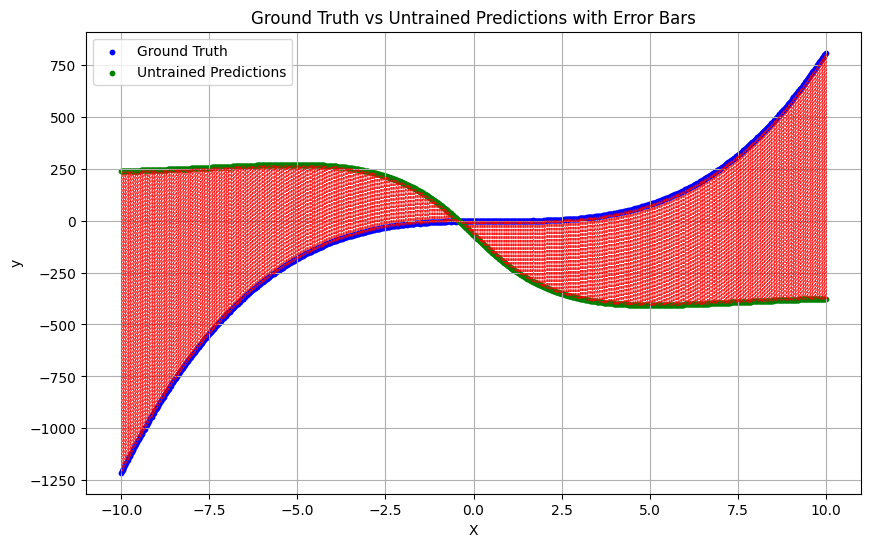

In [8]:
# Plot untrained model's predictions
untrained_params = copy.deepcopy(params)
untrained_out = forward(untrained_params, X_norm)
untrained_out = (untrained_out * y.std()) + y.mean()

# Plot ground truth (y) vs input (X)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Ground Truth", color='blue', s=10)

# Plot predictions (untrained_out) vs input (X)
plt.scatter(X, untrained_out, label="Untrained Predictions", color='green', s=10)

# Add vertical error bars (red dotted lines) between predictions and ground truth
for i in range(len(X)):
    plt.plot([X[i], X[i]], [y[i, 0], untrained_out[i, 0]], 'r--', linewidth=0.5)

plt.title("Ground Truth vs Untrained Predictions with Error Bars")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.legend();

In [9]:
# Train model using full batch gradient descent
num_epochs = 1000
log_rate = 100
lr = 0.01
losses = []
train_loop_jit = jit(train_loop)

start_time = time.time()
for i in range(num_epochs):
    # params, loss = train_loop(params, X_norm, y_norm, lr)
    params, loss = train_loop_jit(params, X_norm, y_norm, lr) # train w/ jitted loop
    if (i % log_rate) == 0:
        print(f"Epoch [{i}/{num_epochs}] | Train Loss: {loss:.3f}")
    losses.append(loss)

end_time = time.time()
# Total train time: 11.15 seconds w/o JIT
# Jit: Total train time: 1.12 seconds w/ JIT
print(f"Total train time: {end_time-start_time:.2f} seconds")

Epoch [0/1000] | Train Loss: 2.650
Epoch [100/1000] | Train Loss: 0.100
Epoch [200/1000] | Train Loss: 0.079
Epoch [300/1000] | Train Loss: 0.070
Epoch [400/1000] | Train Loss: 0.062
Epoch [500/1000] | Train Loss: 0.057
Epoch [600/1000] | Train Loss: 0.052
Epoch [700/1000] | Train Loss: 0.047
Epoch [800/1000] | Train Loss: 0.044
Epoch [900/1000] | Train Loss: 0.040
Total train time: 0.22 seconds


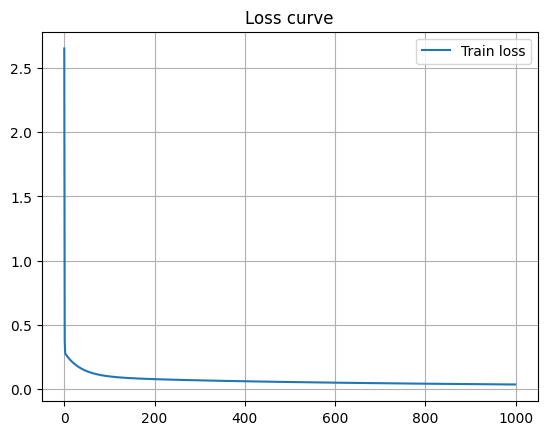

In [10]:
plt.plot(losses, label="Train loss")
plt.title("Loss curve")
plt.grid(True)
plt.legend();

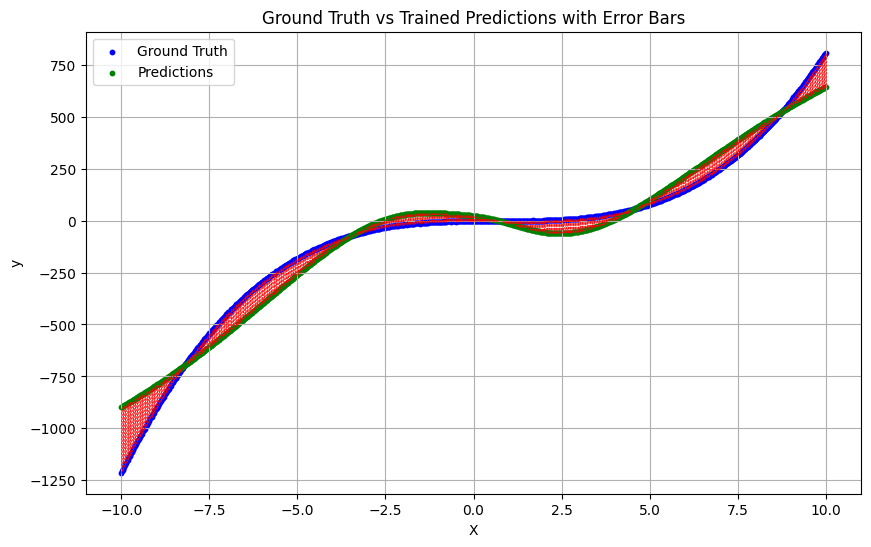

In [11]:
# Make predictions on fully trained model
out = forward(params, X_norm)
out = (out * y.std()) + y.mean()

# Plot ground truth (y) vs input (X)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Ground Truth", color='blue', s=10)

# Plot predictions (out) vs input (X)
plt.scatter(X, out, label="Predictions", color='green', s=10)

# Add vertical error bars (red dotted lines) between predictions and ground truth
for i in range(len(X)):
    plt.plot([X[i], X[i]], [y[i, 0], out[i, 0]], 'r--', linewidth=0.5)

plt.title("Ground Truth vs Trained Predictions with Error Bars")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.legend();

Let's look at the intermediate representation using Jax PR

In [12]:
jax.make_jaxpr(forward)(untrained_params, X)

{ lambda ; a:f32[1,128] b:f32[128,1] c:f32[128] d:f32[1] e:f32[1000,1]. let
    f:f32[1000,128] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e a
    g:f32[1,128] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 128)] c
    h:f32[1000,128] = add f g
    i:f32[1000,128] = tanh h
    j:f32[1000,1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] i b
    k:f32[1,1] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 1)] d
    l:f32[1000,1] = add j k
  in (l,) }

## PyTrees

In [13]:
import operator

In [14]:
tree1 = [1, 2, 3]
tree2 = [(1, -2), (3, 4), 5]
tree3 = {"w1": 1.0, "w2": jnp.ones((3, 3)), "inner": {"w3": jnp.zeros((3, 3))}}

In [15]:
for i, tree in enumerate([tree1, tree2, tree3], 1):
    flattened_tree, _ = jax.tree.flatten(tree)
    print(f"Number of leaves in tree{i}: {len(flattened_tree)}")

Number of leaves in tree1: 3
Number of leaves in tree2: 5
Number of leaves in tree3: 3


In [16]:
vals, treedef = jax.tree.flatten(tree2)
reduced_val = jax.tree.reduce(operator.mul, tree2)
mapped_tree = jax.tree.map(lambda x: -x, tree2)
print(f"Original PyTree: {tree2}")
print(f"Reduced PyTree (multiplication): {reduced_val}")
print(f"Mapped PyTree (invert vals): {mapped_tree}")
print(f"Flattened PyTree: {vals}")
print(f"Tree definition: {treedef}")

Original PyTree: [(1, -2), (3, 4), 5]
Reduced PyTree (multiplication): -120
Mapped PyTree (invert vals): [(-1, 2), (-3, -4), -5]
Flattened PyTree: [1, -2, 3, 4, 5]
Tree definition: PyTreeDef([(*, *), (*, *), *])
